# Model Training and Validation Section

## Purpose
Train and validate six different classification models on the provided handwriting digit training dataset.  
Hyperparameters are tuned using training/validation procedures, and model performance is compared across all methods.

## Inputs
- **project_1_training.csv**  
  Labeled digit image data used for training and validation.

## Outputs
- Trained versions of all six classification models with selected hyperparameters  
- A comparison figure showing training/validation accuracy for all models (model_comparison_accuracy.png)
- Saved model objects (used later in model testing section)  
- Identification of the best-performing model for final test prediction

## Import Data

In [7]:
import pandas as pd

train_df = pd.read_csv("training.csv")
print(train_df.shape)
train_df.head()

(21000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## inspect missingness

In [8]:
train_df.isnull().sum().sum()

# No missing values were found in the training dataset.
# All pixel features are fully observed.

np.int64(0)

## check pixel range

In [9]:
y = train_df["label"]
X = train_df.drop(columns=["label"])

print(X.min().min(), X.max().max())

# Pixel intensity values are within the expected grayscale range (0–255),
# so no additional cleaning or correction is needed.

0 255


## drop constant features 

In [10]:
import numpy as np

print("Checking for constant features...\n")

# Calculate variance of each feature
variances = X.var()

# Identify constant features (variance == 0)
constant_features = variances[variances == 0].index.tolist()

num_constant = len(constant_features)

print(f"Total features before dropping: {X.shape[1]}")
print(f"Number of constant features found: {num_constant}")

if num_constant > 0:
    print("\nDropping constant features...")
    X = X.drop(columns=constant_features)
else:
    print("\nNo constant features found.")

print(f"\nTotal features after dropping: {X.shape[1]}")
print("Done.")

Checking for constant features...

Total features before dropping: 784
Number of constant features found: 89

Dropping constant features...

Total features after dropping: 695
Done.


## kNN Training and validation

kNN Cross-Validation Sweep (NO SCALING)
Candidate k values: [1, 3, 5, 7, 9, 11]
CV strategy: StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Distance metric: Euclidean (minkowski, p=2) [default]
Weights: distance
Preprocessing: None
Scoring metric: accuracy

[k= 1] CV accuracy = 0.9575 ± 0.0036
[k= 3] CV accuracy = 0.9597 ± 0.0025
[k= 5] CV accuracy = 0.9585 ± 0.0036
[k= 7] CV accuracy = 0.9574 ± 0.0030
[k= 9] CV accuracy = 0.9556 ± 0.0037
[k=11] CV accuracy = 0.9530 ± 0.0034

Best: k=3, CV accuracy=0.9597 ± 0.0025



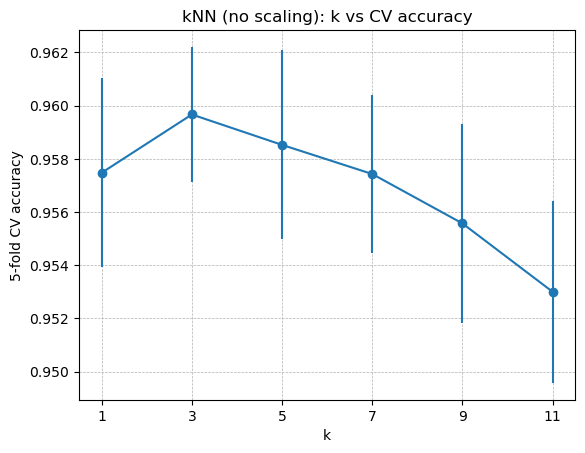

Saved model to: best_knn_model_no_scaling.joblib
Model: Pipeline(KNeighborsClassifier), k=3, weights=distance


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone
import joblib

# -----------------------------
# Settings
# -----------------------------
k_values = list(range(1, 12, 2))
cv_folds = 5
random_state = 42
use_distance_weights = True

weights_mode = "distance" if use_distance_weights else "uniform"

print("==============================================")
print("kNN Cross-Validation Sweep (NO SCALING)")
print("==============================================")
print(f"Candidate k values: {k_values}")
print(f"CV strategy: StratifiedKFold(n_splits={cv_folds}, shuffle=True, random_state={random_state})")
print("Distance metric: Euclidean (minkowski, p=2) [default]")
print(f"Weights: {weights_mode}")
print("Preprocessing: None")
print("Scoring metric: accuracy")
print("==============================================\n")

knn_pipeline_template = Pipeline([
    ("knn", KNeighborsClassifier(weights=weights_mode, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

results = []
for k in k_values:
    model = clone(knn_pipeline_template)
    model.set_params(knn__n_neighbors=k)

    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    results.append({"k": k, "mean_acc": scores.mean(), "std_acc": scores.std()})
    print(f"[k={k:2d}] CV accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

best = sorted(results, key=lambda d: (-d["mean_acc"], d["k"]))[0]
best_k = best["k"]

print(f"\nBest: k={best_k}, CV accuracy={best['mean_acc']:.4f} ± {best['std_acc']:.4f}\n")

# Plot
ks = [r["k"] for r in results]
means = [r["mean_acc"] for r in results]
stds = [r["std_acc"] for r in results]

plt.figure()
plt.errorbar(ks, means, yerr=stds, fmt="o-")
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("5-fold CV accuracy")
plt.title("kNN (no scaling): k vs CV accuracy")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Fit and save
best_model = clone(knn_pipeline_template)
best_model.set_params(knn__n_neighbors=best_k)
best_model.fit(X, y)

model_path = "best_knn_model_no_scaling.joblib"
joblib.dump(best_model, model_path)

print(f"Saved model to: {model_path}")
print(f"Model: Pipeline(KNeighborsClassifier), k={best_k}, weights={weights_mode}")

## Artificial Neural Network Training and Validation

FAST MLP Hyperparameter Search (RandomizedSearchCV)
Library/function: sklearn.neural_network.MLPClassifier
Preprocessing: MinMaxScaler() inside Pipeline (prevents leakage)
Tuning CV: 3-fold StratifiedKFold (fast)
Random configs to try: 6
MLP tuning max_iter: 50 (faster runs)
Fixed: solver='adam', activation='relu', early_stopping=False
Scoring metric: accuracy
---------------------------------------------------
hidden_layer_sizes candidates: [(128,), (256,)]
alpha sampled from: [1e-4, 1e-2] (log-uniform)
learning_rate_init sampled from: [1e-3, 1e-2] (log-uniform)

Starting randomized tuning search...

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Tuning complete.
Best params from tuning:
  -> hidden_layer_sizes  = (256,)
  -> alpha               = 1.10e-04
  -> learning_rate_init  = 5.27e-03
  -> Best tuning CV acc   = 0.9680

Running FINAL evaluation with 5-fold Stratified CV (report estimate)...
FINAL 5-FOLD CV RESULT (selected configuration)
CV accuracy = 0.9716 ± 0.0

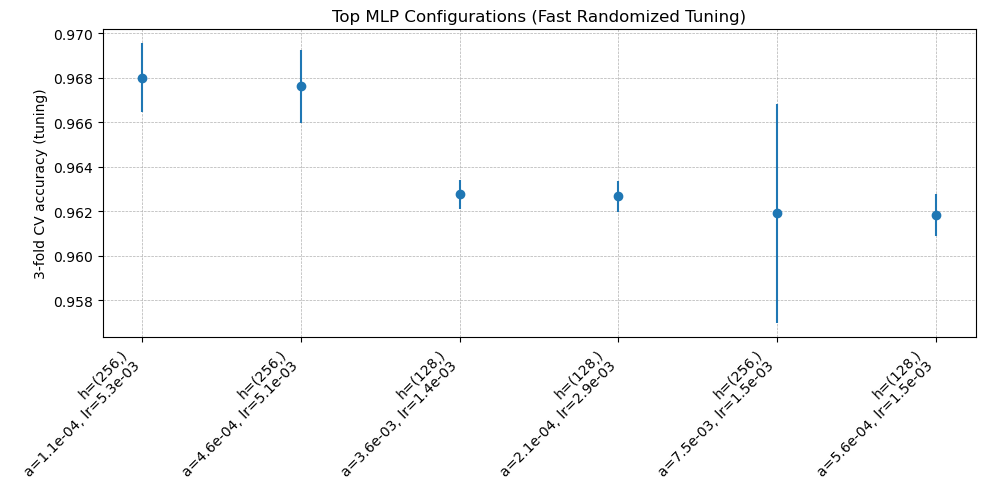

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from scipy.stats import loguniform
import joblib

# ============================================================
# ULTRA-LEAN MLP TUNING (FAST) + FINAL 5-FOLD CV CHECK
# ============================================================
random_state = 42

# --- FAST TUNING SETTINGS (keep this quick) ---
cv_tune_folds = 3
n_iter_search = 6        # only 6 random configs
max_iter_tune = 50       # fewer epochs for speed

# --- FINAL EVALUATION SETTINGS (report-quality estimate) ---
cv_final_folds = 5
max_iter_final = 200     # train longer for final estimate + saved model

# ============================================================
# CV Objects (Stratified)
# ============================================================
cv_tune = StratifiedKFold(n_splits=cv_tune_folds, shuffle=True, random_state=random_state)
cv_final = StratifiedKFold(n_splits=cv_final_folds, shuffle=True, random_state=random_state)

# ============================================================
# Pipeline Templates
# - No leakage: scaler is inside the pipeline
# - early_stopping OFF because we are using cross-validation
# ============================================================
pipe_tune = Pipeline([
    ("scaler", MinMaxScaler()),
    ("mlp", MLPClassifier(
        solver="adam",
        activation="relu",
        max_iter=max_iter_tune,
        early_stopping=False,
        random_state=random_state
    ))
])

pipe_final = Pipeline([
    ("scaler", MinMaxScaler()),
    ("mlp", MLPClassifier(
        solver="adam",
        activation="relu",
        max_iter=max_iter_final,
        early_stopping=False,
        random_state=random_state
    ))
])

# ============================================================
# Hyperparameter Search Space (Reduced for speed)
# - hidden_layer_sizes: reduced set (fast + good coverage)
# - alpha + learning_rate_init: sampled log-uniformly (efficient)
# ============================================================
param_distributions = {
    "mlp__hidden_layer_sizes": [(128,), (256,)],         # reduced for speed
    "mlp__alpha": loguniform(1e-4, 1e-2),                # samples values between 1e-4 and 1e-2
    "mlp__learning_rate_init": loguniform(1e-3, 1e-2)    # samples values between 1e-3 and 1e-2
}

print("===================================================")
print("FAST MLP Hyperparameter Search (RandomizedSearchCV)")
print("===================================================")
print("Library/function: sklearn.neural_network.MLPClassifier")
print("Preprocessing: MinMaxScaler() inside Pipeline (prevents leakage)")
print(f"Tuning CV: {cv_tune_folds}-fold StratifiedKFold (fast)")
print(f"Random configs to try: {n_iter_search}")
print(f"MLP tuning max_iter: {max_iter_tune} (faster runs)")
print("Fixed: solver='adam', activation='relu', early_stopping=False")
print("Scoring metric: accuracy")
print("---------------------------------------------------")
print(f"hidden_layer_sizes candidates: {param_distributions['mlp__hidden_layer_sizes']}")
print("alpha sampled from: [1e-4, 1e-2] (log-uniform)")
print("learning_rate_init sampled from: [1e-3, 1e-2] (log-uniform)")
print("===================================================\n")

search = RandomizedSearchCV(
    estimator=pipe_tune,
    param_distributions=param_distributions,
    n_iter=n_iter_search,
    scoring="accuracy",
    cv=cv_tune,
    n_jobs=-1,
    random_state=random_state,
    verbose=1,
    return_train_score=False
)

print("Starting randomized tuning search...\n")
search.fit(X, y)

print("\n===================================================")
print("Tuning complete.")
print("===================================================")
print("Best params from tuning:")
best_params = search.best_params_
print(f"  -> hidden_layer_sizes  = {best_params['mlp__hidden_layer_sizes']}")
print(f"  -> alpha               = {best_params['mlp__alpha']:.2e}")
print(f"  -> learning_rate_init  = {best_params['mlp__learning_rate_init']:.2e}")
print(f"  -> Best tuning CV acc   = {search.best_score_:.4f}")
print("===================================================\n")

# ============================================================
# FINAL 5-FOLD CV CHECK (report-quality estimate)
# - Rebuild the model with max_iter_final for a fair final estimate
# ============================================================
final_model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("mlp", MLPClassifier(
        solver="adam",
        activation="relu",
        hidden_layer_sizes=best_params["mlp__hidden_layer_sizes"],
        alpha=best_params["mlp__alpha"],
        learning_rate_init=best_params["mlp__learning_rate_init"],
        max_iter=max_iter_final,
        early_stopping=False,
        random_state=random_state
    ))
])

print("Running FINAL evaluation with 5-fold Stratified CV (report estimate)...")
final_scores = cross_val_score(final_model, X, y, cv=cv_final, scoring="accuracy", n_jobs=-1)
final_mean = final_scores.mean()
final_std = final_scores.std()

print("===================================================")
print("FINAL 5-FOLD CV RESULT (selected configuration)")
print("===================================================")
print(f"CV accuracy = {final_mean:.4f} ± {final_std:.4f}")
print("===================================================\n")

# ============================================================
# Fit best model on ALL training data and save
# ============================================================
print("Fitting selected best MLP on full training data and saving...")
final_model.fit(X, y)

model_path = "best_mlp_model.joblib"
joblib.dump(final_model, model_path)

print("Saved best model to:", model_path)
print("Model: Pipeline(MinMaxScaler -> MLPClassifier)")
print("===================================================\n")

# ============================================================
# Plot: Top tried configurations from the tuning phase
# ============================================================
results = search.cv_results_
mean_scores = results["mean_test_score"]
std_scores = results["std_test_score"]
params = results["params"]

sorted_idx = np.argsort(mean_scores)[::-1]
top_n = min(6, len(sorted_idx))

top_means = mean_scores[sorted_idx][:top_n]
top_stds = std_scores[sorted_idx][:top_n]
top_params = [params[i] for i in sorted_idx[:top_n]]

labels = [
    f"h={p['mlp__hidden_layer_sizes']}\n"
    f"a={p['mlp__alpha']:.1e}, lr={p['mlp__learning_rate_init']:.1e}"
    for p in top_params
]

plt.figure(figsize=(10, 5))
plt.errorbar(range(top_n), top_means, yerr=top_stds, fmt="o")
plt.xticks(range(top_n), labels, rotation=45, ha="right")
plt.ylabel("3-fold CV accuracy (tuning)")
plt.title("Top MLP Configurations (Fast Randomized Tuning)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## adaboost training and validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ============================================================
# AdaBoost (VERY FAST)
# - 1 stratified validation split
# - staged_predict early stopping to pick best n_estimators
# - tiny grid over (learning_rate, max_depth)
# ============================================================

random_state = 42
max_estimators = 300

# Keep this small for speed
learning_rate_grid = [0.1, 0.5, 1.0]
max_depth_grid = [1, 2]

print("===================================================")
print("AdaBoost: FAST Validation-Split Tuning + Early Stopping")
print("===================================================")
print(f"Data: X shape = {X.shape}, y shape = {y.shape}")
print(f"Max estimators: {max_estimators}")
print(f"learning_rate candidates: {learning_rate_grid}")
print(f"max_depth candidates: {max_depth_grid}")
print("Metric: accuracy")
print("---------------------------------------------------\n")

# 1) Stratified split (fast + fair)
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=random_state
)

best = {
    "val_acc": -1.0,
    "learning_rate": None,
    "max_depth": None,
    "best_n_estimators": None,
    "curve": None
}

# 2) Try small grid over lr and depth
for depth in max_depth_grid:
    for lr in learning_rate_grid:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=depth, random_state=random_state),
            n_estimators=max_estimators,
            learning_rate=lr,
            random_state=random_state
        )

        print(f"Training: depth={depth}, learning_rate={lr} ...")
        model.fit(X_tr, y_tr)

        # 3) Early stopping: check validation accuracy after each stage
        val_acc_curve = []
        best_stage_acc = -1.0
        best_stage_n = None

        for i, y_pred in enumerate(model.staged_predict(X_val), start=1):
            acc = accuracy_score(y_val, y_pred)
            val_acc_curve.append(acc)
            if acc > best_stage_acc:
                best_stage_acc = acc
                best_stage_n = i

        print(f"  -> best val acc={best_stage_acc:.4f} at n_estimators={best_stage_n}")

        if best_stage_acc > best["val_acc"]:
            best.update({
                "val_acc": best_stage_acc,
                "learning_rate": lr,
                "max_depth": depth,
                "best_n_estimators": best_stage_n,
                "curve": val_acc_curve
            })

print("\n===================================================")
print("Selected AdaBoost configuration (from validation split)")
print("===================================================")
print(f"Best validation accuracy: {best['val_acc']:.4f}")
print(f"learning_rate: {best['learning_rate']}")
print(f"max_depth: {best['max_depth']}")
print(f"chosen n_estimators (early-stopped): {best['best_n_estimators']}")
print("===================================================\n")

# 4) Refit best configuration on FULL training data (X, y) and save
final_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best["max_depth"], random_state=random_state),
    n_estimators=best["best_n_estimators"],
    learning_rate=best["learning_rate"],
    random_state=random_state
)

print("Fitting final AdaBoost on full training data...")
final_model.fit(X, y)

model_path = "best_adaboost_model.joblib"
joblib.dump(final_model, model_path)
print(f"Saved model -> {model_path}")

# 5) Plot validation curve for the chosen model (useful for report)
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(best["curve"]) + 1), best["curve"])
plt.xlabel("n_estimators")
plt.ylabel("Validation Accuracy")
plt.title("AdaBoost Validation Accuracy vs. Number of Estimators")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

AdaBoost: FAST Validation-Split Tuning + Early Stopping
Data: X shape = (21000, 695), y shape = (21000,)
Max estimators: 300
learning_rate candidates: [0.1, 0.5, 1.0]
max_depth candidates: [1, 2]
Metric: accuracy
---------------------------------------------------

Training: depth=1, learning_rate=0.1 ...


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


  -> best val acc=0.6655 at n_estimators=299
Training: depth=1, learning_rate=0.5 ...


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


  -> best val acc=0.7769 at n_estimators=271
Training: depth=1, learning_rate=1.0 ...


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


  -> best val acc=0.7855 at n_estimators=288
Training: depth=2, learning_rate=0.1 ...


# Model Testing Section

## Purpose
Load the six trained classification models produced and apply them to the unlabeled handwriting digit testing dataset.  
This notebook generates predicted class labels for the test samples using all six methods and exports the final prediction file from the designated best-performing model.

## Inputs
- **project_1_testing.csv**  
  Unlabeled digit image data used for final prediction.

- **Saved trained model objects**  
  The six trained classifiers (with selected hyperparameters).

## Outputs
- Predicted class labels for the testing dataset from each of the six models  
- **prediction.csv**  
  Final prediction results from the best model (used for grading and error-rate evaluation)